# Elena's diapers

In [322]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns
from calendar import monthrange
import matplotlib.dates as mdates
from dateutil.relativedelta import relativedelta


sns.set_theme()

df_pee = pd.read_pickle("pee_modified.pkl")
df = pd.read_csv("excretions.csv")
df.columns = [col.replace(" ", "") for col in df.columns]

In [323]:
df_poo = df[(df["Type"] == "Poo") | (df["Type"] == "Pee and Poo")]
df_pee["hour"] = df_pee.apply(lambda x: x["datetime"].hour, axis=1)
# day_masker = (df_pee["hour"] < 21) & (df_pee["hour"] > 7)
# df_pee = df_pee[day_masker]



In [324]:
df_pee["Mica"].unique()

array([True, False, None], dtype=object)

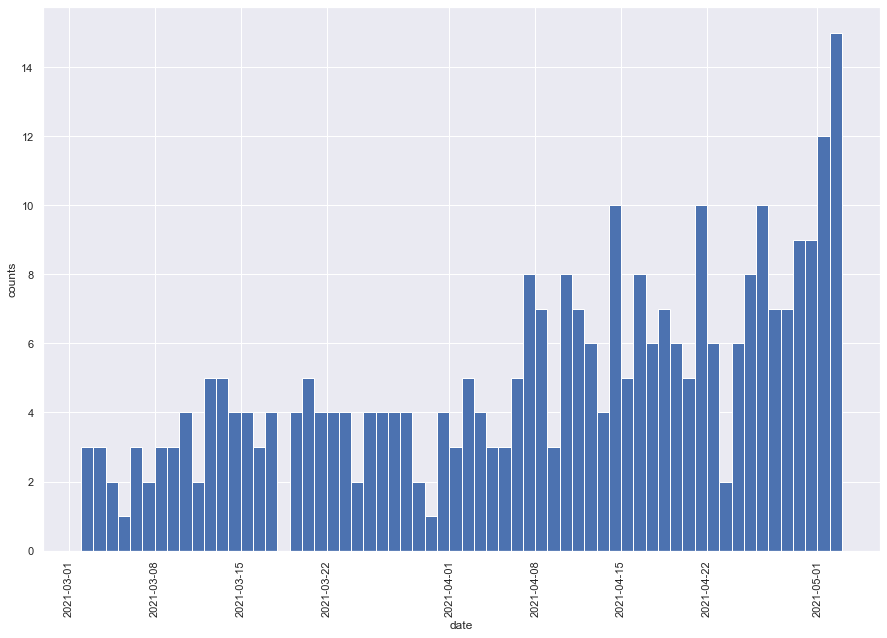

In [121]:
min_time = df_pee["datetime"].min()
mean_time = df_pee["datetime"].mean()
max_time = df_pee["datetime"].max()
timedelta = max_time - min_time
bins = timedelta.days + 1
fig, ax = plt.subplots(figsize=(15, 10))
min_time = min_time.replace(hour=0, minute=0, second=0)
max_time = max_time.replace(day=max_time.day + 1, hour=0, minute=0, second=0)
custom_bins = pd.date_range(start=min_time, end=max_time).to_pydatetime().tolist()
ax.hist(df_pee["datetime"], bins=custom_bins)
plt.xticks(rotation=90)
plt.xlabel("date")
plt.ylabel("counts")
plt.show()

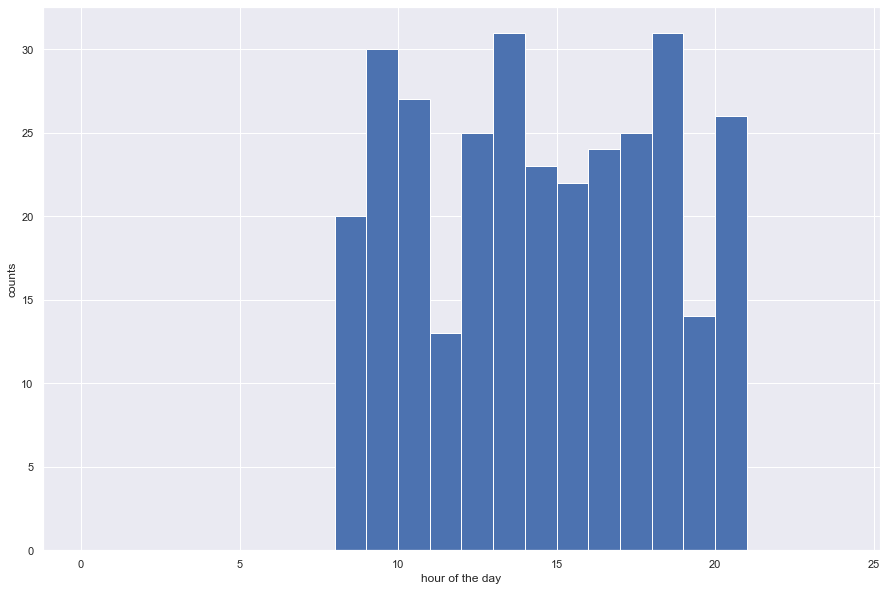

In [68]:
bins = np.linspace(0, 24, 25)
fig, ax = plt.subplots(figsize=(15, 10))
ax.hist(df_pee["hour"], bins=bins)
ax.set_xlabel("hour of the day")
ax.set_ylabel("counts")
plt.show()

In [69]:
df_feed = pd.read_csv("feeds.csv")
df_feed.columns = [col.replace(" ", "") for col in df_feed.columns]
df_feed.head()

,id,StartTime,EndTime,FeedType,Quantity(oz),Quantity(mlorg),Notes,Duration(Minutes),FoodType,Unit,BottleType
0,794,18:47:08 05-02-2021,18:55:50 05-02-2021,Right Breast,NaN,NaN,NaN,8,Breast Milk,NaN,NaN
1,793,17:51:32 05-02-2021,18:00:55 05-02-2021,Left Breast,NaN,NaN,NaN,9,Breast Milk,NaN,NaN
2,792,15:03:51 05-02-2021,15:21:48 05-02-2021,Left Breast,NaN,NaN,NaN,17,Breast Milk,NaN,NaN
3,790,12:12:21 05-02-2021,12:14:19 05-02-2021,Left Breast,NaN,NaN,NaN,1,Breast Milk,NaN,NaN
4,789,11:57:01 05-02-2021,12:08:56 05-02-2021,Right Breast,NaN,NaN,NaN,11,Breast Milk,NaN,NaN


In [70]:
df_feed["start"] = df_feed.apply(lambda x: datetime.strptime(x["StartTime"], '%H:%M:%S %m-%d-%Y'), axis=1)
df_feed["end"] = df_feed.apply(lambda x: datetime.strptime(x["EndTime"], '%H:%M:%S %m-%d-%Y'), axis=1)

In [71]:
l_times_to_pee = []
for time in df_feed["end"]:
    df_pee["timediff"] = df_pee["datetime"] - time
    df_pee["timediff_day"] = df_pee.apply(lambda x: x["timediff"].days, axis=1)
    test_df = df_pee[df_pee["timediff_day"] >= 0]
    l_times_to_pee.append(np.min(test_df["timediff"])) 
    
df_feed["time_to_pee"] = l_times_to_pee

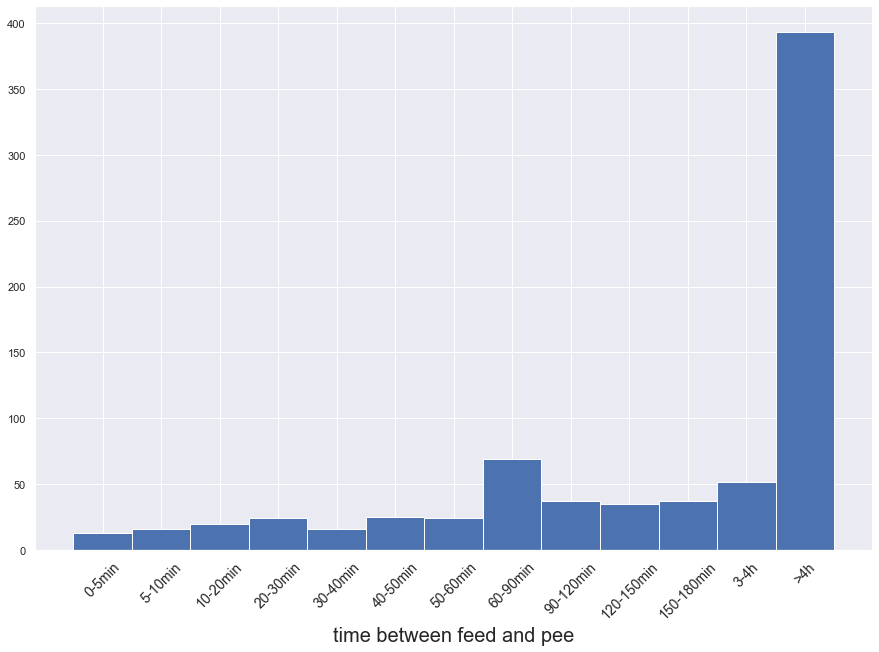

In [73]:
bins = np.linspace(0, 60, 61)
fig, ax = plt.subplots(figsize=(15, 10))
df_feed["time_to_pee"] = pd.to_timedelta(df_feed["time_to_pee"])
df = df_feed
df = df.set_index((df['time_to_pee']))
bins = [
    pd.Timedelta(minutes = 0),
    pd.Timedelta(minutes = 5),
    pd.Timedelta(minutes = 10),
    pd.Timedelta(minutes = 20),
    pd.Timedelta(minutes = 30),
    pd.Timedelta(minutes = 40),
    pd.Timedelta(minutes = 50),
    pd.Timedelta(minutes = 60),
    pd.Timedelta(minutes = 90),
    pd.Timedelta(minutes = 120),
    pd.Timedelta(minutes = 150),
    pd.Timedelta(minutes = 180),
    pd.Timedelta(hours = 4),
    pd.Timedelta(days = 99)
]
labels = ['0-5min', '5-10min', '10-20min', '20-30min', '30-40min',
          "40-50min",
          "50-60min",
          "60-90min",
          "90-120min",
          "120-150min",
          "150-180min",
          "3-4h", ">4h"
         ]
int_bins = list(range(len(labels)))
old_bins = int_bins
df_feed['bins'] = pd.cut(df_feed['time_to_pee'], bins=bins, labels=int_bins)
int_bins = [i - 0.5 for i in int_bins]
int_bins.append(int_bins[-1] + 1)
plt.hist(df_feed["bins"], bins=int_bins)
plt.xticks(old_bins, labels, fontsize=14, rotation=45)
plt.xlabel("time between feed and pee", fontsize=20)
# plt.ylabel(fontsize=14)
plt.show()

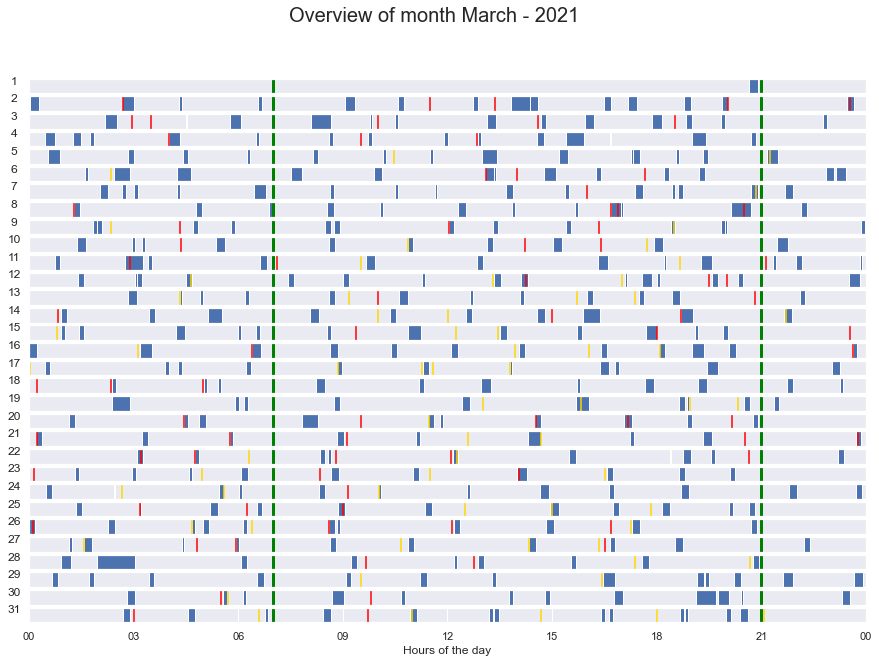

In [285]:
l_handles = []
def plot_day(month_to_plot, start_cut, end_cut, df_feed, df_pee, ax=None, handles=[]):
    if ax is None:
        fig, ax = plt.subplots(figsize=(15, 10), nrows=1, ncols=1)
    day = start_cut.day
    for idx, (start, end) in enumerate(zip(df_feed["start"], df_feed["end"])):
        p0 = ax.axvspan(start, end, label="food")
        handles.append(p0)
    for pee, note in zip(df_pee["datetime"], df_pee["Notes"]):
        try:
            mod_note = note.lower()
            if "mica:" in mod_note and "true" in mod_note:
                color = "gold"
            elif "en la mica" in mod_note:
                color = "gold"
            else:
                color = "red"

            if color == "gold":
                label = "pee (mica)"
                p1 = ax.axvline(pee, color=color, label=label)
                handles.append(p1)
            elif color == "red":
                label = "pee"
                p3 = ax.axvline(pee, color=color, label=label)
                handles.append(p3)
        except:
            p1 = ax.axvline(pee, color="red", label="pee")
            handles.append(p1)
            
    ax.set_xlim(start_cut, end_cut)
    bed_time = start_cut.replace(hour=21)
    p2 = ax.axvline(bed_time, color='green', linewidth=3, label="Wake up/Sleep time")
    handles.append(p2)
    getup_time = start_cut.replace(hour=7)
    ax.axvline(getup_time, color='green', linewidth=3)
    ax.set_yticks([])
    ax.set_ylabel(day, rotation=0, labelpad=15)
    return handles
    
def plot_month(year, month, df_pee, df_feed):
    month_details = monthrange(year, month)
    fig, axs = plt.subplots(figsize=(15, 10), nrows=month_details[1], ncols=1)

    start_cut = datetime(year=year, month=month, day=1, hour=0, minute=0)
    end_cut = start_cut + relativedelta(months=+1)

    month_year = start_cut.strftime("%B - %Y")
    fig.suptitle("Overview of month {info}".format(info=month_year), fontsize=20)

    custom_bins = pd.date_range(start=start_cut, end=end_cut).to_pydatetime().tolist()
    for idx, (ax, start_cut, end_cut) in enumerate(zip(axs, custom_bins[:-1], custom_bins[1:])):
        this_pee = df_pee[(df_pee["datetime"] > start_cut) & (df_pee["datetime"] < end_cut)]
        this_feed = df_feed[(df_feed["end"] > start_cut) & (df_feed["start"] < start_cut)]
        handles = plot_day(month_to_plot=month,
                 start_cut=start_cut,
                 end_cut=end_cut,
                 df_feed=df_feed,
                 df_pee=this_pee,
                 ax=ax)
        if idx != len(axs) - 1:
            ax.set_xticks([])
        else:
            myFmt = mdates.DateFormatter('%H')
            ax.xaxis.set_major_formatter(myFmt)
            ax.set_xlabel("Hours of the day")

    # axs[0].legend(handles=handles, ncol=6, bbox_to_anchor=(0.5, 3.5), loc='upper center')

plot_month(year=2021, month=3, df_pee=df_pee, df_feed=df_feed)
plt.savefig("activity_march.png", dpi=300)
plt.show()


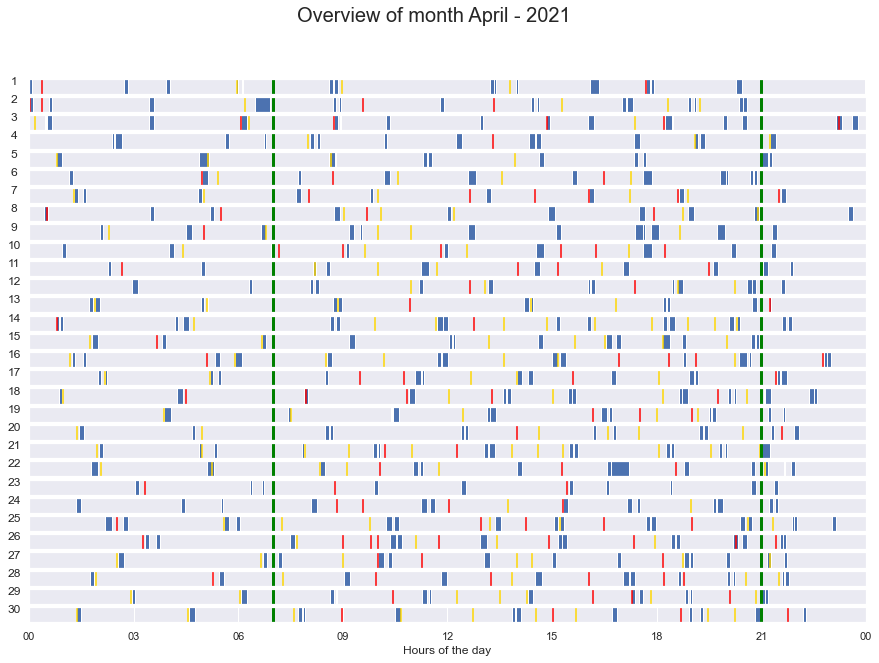

In [284]:
plot_month(year=2021, month=4, df_pee=df_pee, df_feed=df_feed)
plt.savefig("activity_april.png", dpi=300)
plt.show()

In [140]:
masking = (df_pee["datetime"] > datetime(year=2021, month=5, day=1, hour=0, minute=0)) & (df_pee["datetime"] < datetime(year=2021, month=5, day=2, hour=0, minute=0))
df_pee[masking]

,id,Time,Type,Notes,datetime,hour
18,576,21:35:17 05-01-2021,Pee,En la mica,2021-05-01 21:35:17,21
19,575,20:19:24 05-01-2021,Pee,En la mica,2021-05-01 20:19:24,20
20,574,19:30:51 05-01-2021,Pee,En la mica,2021-05-01 19:30:51,19
21,573,18:30:23 05-01-2021,Pee,En la mica,2021-05-01 18:30:23,18
22,572,17:57:01 05-01-2021,Pee,Pañal mojado,2021-05-01 17:57:01,17
23,571,17:15:26 05-01-2021,Pee,En la mica,2021-05-01 17:15:26,17
25,569,15:48:40 05-01-2021,Pee,In mica Windel trocken,2021-05-01 15:48:40,15
26,568,14:47:51 05-01-2021,Pee,En la mica,2021-05-01 14:47:51,14
27,567,13:59:18 05-01-2021,Pee,En la mica,2021-05-01 13:59:18,13
28,566,13:50:13 05-01-2021,Pee,Pañal mojado,2021-05-01 13:50:13,13


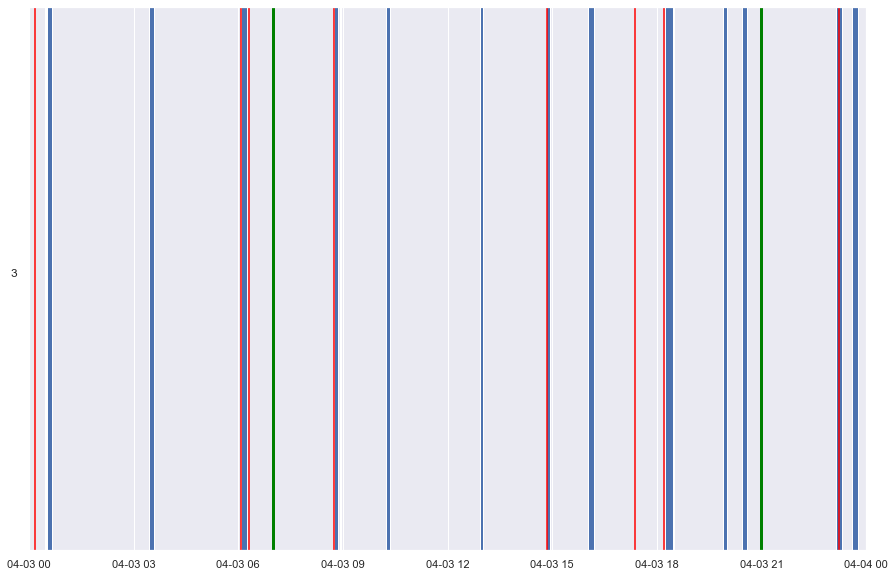

In [206]:

month_to_plot = 4
month_details = monthrange(2021, month_to_plot)
start_cut = datetime(year=2021, month=month_to_plot, day=3, hour=0, minute=0)
end_cut = datetime(year=2021, month=month_to_plot, day=4, hour=0, minute=0)
custom_bins = pd.date_range(start=start_cut, end=end_cut).to_pydatetime().tolist()

def plot_day(month_to_plot, start_cut, end_cut, df_feed, df_pee, ax=None):
    if ax is None:
        fig, ax = plt.subplots(figsize=(15, 10), nrows=1, ncols=1)
    day = start_cut.day
    for idx, (start, end) in enumerate(zip(df_feed["start"], df_feed["end"])):
        ax.axvspan(start, end)
    for pee in df_pee["datetime"]:
        ax.axvline(pee, color="red")
    ax.set_xlim(start_cut, end_cut)
    bed_time = start_cut.replace(hour=21)
    ax.axvline(bed_time, color='green', linewidth=3)
    getup_time = start_cut.replace(hour=7)
    ax.axvline(getup_time, color='green', linewidth=3)
    ax.set_yticks([])
    ax.set_ylabel(day, rotation=0, labelpad=15)
    
plot_day(month_to_plot=month_to_plot, start_cut=start_cut, end_cut=end_cut, df_feed=df_feed, df_pee=df_pee)

In [237]:
start_cut.strftime("%B")

'April'

In [300]:
l_occurences = []
for note in df_pee["Notes"]:
    try:
        mod_note = note.lower()
        if mod_note == "en la mica y pañal mojado":
            continue
        elif mod_note == "mica: true  windel: trocken":
            continue
        elif mod_note == "en la mica":
            continue
        elif mod_note == "pañal mojado":
            continue
        elif mod_note == "pañal mojado y en la mica":
            continue
        elif mod_note == "en el pañal":
            continue
        elif mod_note == "en el pañal y en la mica":
            continue
        elif mod_note == "en la mica":
            continue
        else:
            l_occurences.append(mod_note)
    except:
        pass
for item in set(l_occurences):
    print(item)

en la mica después de llegar
pipi in mica  windel trocken
in die mica
15 después de comer. se despertó. cuerpo tenso. pipi
in mica  windel trocken
pipi in mica. windel feucht
en el cambiador. 
in windel
en la mica y pañal mojado. después de despertarse
pañal
mica! trocken!
en la mica. wurde unruhig beim wickeln
pañal lleno. después del baño en la toalla
in die windel
windel nass
en el pañal y un poquito en la mica
mica y pañal mojado
en la mica y pañal lleno
windel leer  pipi ins töpfchen
en la mica un poquito y pañal mojado
windel und töpfchen
mica  windel trocken
windel voll und in töpfchen
en la mica!
en la mica y pañal
en el cambiador y pañal mojado
en la mica  y el pañal mojado. lloró antes de hacer pipí
pañal lleno
in die mica. windel nass
in das töpfchen! windel feucht
während nackt zeit
pañal lleno y pipí en la mica
mica und nass
mica y pañal lleno
en la mica. wurde unruhig beim schlafen. 
en la mica. apenas se despertó. pañal mojado
en el cambiador
mica und windel nass
en la m

In [276]:
df_poo

,id,Time,Type,Notes
24,570,16:50:01 05-01-2021,Poo,En el pañal
43,551,12:54:06 04-30-2021,Poo,En la mica
54,539,16:14:10 04-29-2021,Poo,En la mica
91,503,12:01:45 04-26-2021,Poo,En la mica
116,478,08:55:39 04-24-2021,Poo,En la mica
118,476,21:08:14 04-23-2021,Poo,En la mica
123,471,18:34:14 04-22-2021,Poo,En la mica
150,443,16:25:27 04-20-2021,Poo,En la mica
153,440,10:50:17 04-20-2021,Poo,In die Windel
181,413,14:45:16 04-17-2021,Poo,Un poquito en el pañal y después en la mica. L...
